# From roots to cribs: an exploration of ethnicity and baby naming trends in New York City

#### Summary
In bustling metropolises, diverse ethnicities coexist. Despite residing side by side, these communities exhibit unique traits in their culinary preferences, fashion choices, and linguistic nuances. This project delves into yet another difference: the names these ethnicities give to their children. Focusing on the unparalleled multiculturalism of New York City, this study draws upon [a comprehensive dataset available on the US Government' Open Data portal](https://catalog.data.gov/dataset/popular-baby-names) spanning the years 2011 to 2019, documenting every name given to newborns in the city. The dataset categorizes names by gender and four overarching ethnic groups: Asian-Pacific Islander, Black, Hispanic, and White. Analyzing this wealth of data, I explore frequent names and examine the variations in their popularity across different ethnicities. Additionally, I introduce a measure of naming overlap, shedding light on which communities share similar naming trends and which boast distinctive naming conventions. The study concludes by investigating whether names experienced an increase or decrease in shared usage throughout the 2010s decade.

## 1. Load libraries
We first need to load the libraries we'll need for wrangling, stats and visualization.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ttest_rel
import statsmodels.api as sm

## 2. Define graphical parameters
Let's now customize some data display options. To make the various figures we'll build more visually pleasing, we'll also tweak a few plotting parameters.

In [2]:
#set max rows and columns when displaying data
pd.set_option('display.max_columns', None) #no maximum number of columns
pd.set_option('display.max_rows', 25) #maximum number of rows

#set font sizes
font_size_regular = 12
plt.rcParams.update({
    'font.size': font_size_regular + 2,
    'axes.labelsize': font_size_regular,
    'xtick.labelsize': font_size_regular - 2,
    'ytick.labelsize': font_size_regular - 2,
    'axes.titlesize': font_size_regular,
    'legend.title_fontsize': font_size_regular,
    'legend.fontsize': font_size_regular - 2,
    'figure.titlesize': font_size_regular + 2
})

#set plot sizes
plot_size_fullwidth = 12 #width of a figure taking the whole width of the page
plot_size_onerowheight = 4 #height of a one-row figure

#define function to apply common settings to the axes
def apply_common_settings(ax):
    ax.spines['top'].set_visible(False)  #remove top spine
    ax.spines['right'].set_visible(False)  #remove right spine
    ax.spines['left'].set_linewidth(1)  #thickness of left spine
    ax.spines['bottom'].set_linewidth(1)  #thickness of bottom spine
    ax.tick_params(axis='both', which='both', width=1) #tick thickness

#define color palette to use when plotting by ethnicities
palette_ethnicities = ['#E65898', '#B1C019', '#FDC903', '#C1A471']

## 3. Load dataset

Next we'll load the dataset of interest for this project. We'll be using the .csv file that can be downloaded from [the US government's Open Data portal](https://catalog.data.gov/dataset/popular-baby-names).

In [3]:
#load as DataFrame
df_babynames = pd.read_csv('Popular_Baby_Names.csv')

#display the DataFrame
display(df_babynames)

,Year of Birth,Gender,Ethnicity,Child's First Name,Count,Rank
0,2011,FEMALE,HISPANIC,GERALDINE,13,75
1,2011,FEMALE,HISPANIC,GIA,21,67
2,2011,FEMALE,HISPANIC,GIANNA,49,42
3,2011,FEMALE,HISPANIC,GISELLE,38,51
4,2011,FEMALE,HISPANIC,GRACE,36,53
...,...,...,...,...,...,...
57577,2014,MALE,WHITE NON HISPANIC,Yousef,18,94
57578,2014,MALE,WHITE NON HISPANIC,Youssef,24,88
57579,2014,MALE,WHITE NON HISPANIC,Yusuf,16,96
57580,2014,MALE,WHITE NON HISPANIC,Zachary,90,39


This dataset has 57582 rows and 6 columns. The column names are quite straightforward, but we could simplify them a bit more. We'll do that just below.

## 3. Data preparation

Let's start by tweaking some things we could already see while displaying the data above. I usually like my column names to contain no spaces, and to be all lowercase. Apart from that, we can see some lack of consistency with respect to how `Child's First Name` is written. Let's unify the values of that column by reformatting them as strings with a capitalized initial. While we're at it, let's make our other string variables be all lowercase.

In [4]:
#rename columns
df_babynames = df_babynames.set_axis(['year_born', 'gender', 'ethnicity', 'name','count','rank'], axis=1)

#reformat
df_babynames[['gender','ethnicity']] = df_babynames[['gender','ethnicity']].apply(lambda col: col.str.lower()) #make gender and ethnicity be lower case
df_babynames['name'] = df_babynames['name'].str.capitalize() #make name be lower case with upper case initial

#display the DataFrame and show the data types
display(df_babynames)
display(df_babynames.dtypes)

,year_born,gender,ethnicity,name,count,rank
0,2011,female,hispanic,Geraldine,13,75
1,2011,female,hispanic,Gia,21,67
2,2011,female,hispanic,Gianna,49,42
3,2011,female,hispanic,Giselle,38,51
4,2011,female,hispanic,Grace,36,53
...,...,...,...,...,...,...
57577,2014,male,white non hispanic,Yousef,18,94
57578,2014,male,white non hispanic,Youssef,24,88
57579,2014,male,white non hispanic,Yusuf,16,96
57580,2014,male,white non hispanic,Zachary,90,39


year_born     int64
gender       object
ethnicity    object
name         object
count         int64
rank          int64
dtype: object

That's more like it! Each row describes the number of times (and associated rank) within a particular year a baby of a specific gender and ethnicity was given a name in the City of New York. The information is specified in the following columns:

- `year_born`: a numeric column, ranging from 2011 to 2019, indicating the year of birth.
- `gender`: text column identifying that row carrying data either for 'female' or 'male'.
- `ethnicity`: text specifying the ethnicity.
- `name`: text with the given name the row includes information for.
- `count`: a numeric column with integers indicating the number of times a baby of that gender and ethnicity and born on that year was given that specific name.
- `rank`: integer specifying the rank that name occupies, in terms of frequency, within that gender, ethnicity and year.

But there's a bit more to be done before starting to have fun with the dataset. Let's take a closer look at the way the values of `ethnicity` are coded.

In [5]:
display(pd.unique(df_babynames['ethnicity']))

array(['hispanic', 'white non hispanic', 'asian and pacific islander',
       'black non hispanic', 'asian and paci', 'black non hisp',
       'white non hisp'], dtype=object)

Oh, that's messy. The ethnicity we normally call white, for instance, is sometimes coded as _white non hispanic_, and sometimes as _white non hisp_. Under the current coding we could incur into problems like pandas interpreting these as two different categories. Let's tidy it up.

In [6]:
#unify ethnicity categories by giving the same name to any string starting the same way
df_babynames['ethnicity']=np.where(df_babynames['ethnicity'].str.startswith('asian'),'asian',df_babynames['ethnicity'])
df_babynames['ethnicity']=np.where(df_babynames['ethnicity'].str.startswith('black'),'black',df_babynames['ethnicity'])
df_babynames['ethnicity']=np.where(df_babynames['ethnicity'].str.startswith('white'),'white',df_babynames['ethnicity'])

display(pd.unique(df_babynames['ethnicity']))

array(['hispanic', 'white', 'asian', 'black'], dtype=object)

Well, that's better. We now have four categories: _asian_, _black_, _hispanic_ and _white_. I have the feeling the dataset may hide some other problems. A priori, we would expect this data to have only one row for each combination of `name`, `year_born`, `gender` and `ethnicity`, right? Well, let's make sure it's this way by, for instance, displaying the rows containing the information for baby girls named Grace whose ethnicity is Asian.

In [7]:
#display rows matching those conditions
display(df_babynames.loc[ (df_babynames['name'] == 'Grace') & (df_babynames['gender'] == 'female') & (df_babynames['ethnicity'] == 'asian') ])

#see how many rows are duplicates
display(df_babynames.duplicated().value_counts()) 

,year_born,gender,ethnicity,name,count,rank
1020,2011,female,asian,Grace,33,16
2471,2011,female,asian,Grace,33,16
4030,2012,female,asian,Grace,51,8
6202,2017,female,asian,Grace,44,11
6332,2013,female,asian,Grace,51,9
...,...,...,...,...,...,...
48268,2018,female,asian,Grace,50,9
49577,2011,female,asian,Grace,33,16
51548,2012,female,asian,Grace,51,8
53546,2013,female,asian,Grace,51,9


True     39529
False    18053
Name: count, dtype: int64

29 rows... That's way more than the 9 we expect, one for each year from 2011 to 2019. In the code chunk above I also printed the amount of duplicate rows this dataset has. And it's 39529, more than the non-duplicate ones (18053). Oh my, this is a messy dataset! Most likely redundant information was added to the dataset before it was uploaded. Let's delete the duplicates and check again.

In [8]:
#keep only first of repeated rows, drop duplicates
df_babynames = df_babynames.drop_duplicates() 

#display rows matching those conditions
display(df_babynames.loc[ (df_babynames['name'] == 'Grace') & (df_babynames['gender'] == 'female') & (df_babynames['ethnicity'] == 'asian') ])

#see how many rows are duplicates
display(df_babynames.duplicated().value_counts()) 


,year_born,gender,ethnicity,name,count,rank
1020,2011,female,asian,Grace,33,16
4030,2012,female,asian,Grace,51,8
6202,2017,female,asian,Grace,44,11
6332,2013,female,asian,Grace,51,9
11904,2014,female,asian,Grace,64,7
31439,2015,female,asian,Grace,65,6
31599,2016,female,asian,Grace,54,9
38258,2019,female,asian,Grace,48,8
48268,2018,female,asian,Grace,50,9


False    18053
Name: count, dtype: int64

Only 9 rows this time (one per year), and not a single duplicate in our DataFrame. Now we're talking!

Before we start having fun exploring the data, let's do one more thing. Right now we have a dataframe giving us information split per year. Sometimes we'll want to dig into trends across years, but other times we'll prefer to focus on general differences between variables, without placing that much focus on the yearly information. In order to be able work in these latter cases, we'll create a new dataframe where we pool the `count`column over years, and we'll calculate its respective `rank`.

In [9]:
#create DataFrame pooling over years
df_babynames_pooled = df_babynames.copy().groupby(['gender','ethnicity','name'], as_index=False)["count"].sum() #sum counts across years

#create the new 'rank' column, this time disregarding year information
df_babynames_pooled['rank'] = df_babynames_pooled.groupby(['gender', 'ethnicity'])['count'].rank(ascending=False, method='min')

#display DataFrame
display(df_babynames_pooled)

#display rows matching previous conditions of interest in the new pooled DataFrame
display(df_babynames_pooled.loc[ (df_babynames_pooled['name'] == 'Grace') & (df_babynames_pooled['gender'] == 'female') & (df_babynames_pooled['ethnicity'] == 'asian') ])


,gender,ethnicity,name,count,rank
0,female,asian,Aaliyah,21,241.0
1,female,asian,Aarya,21,241.0
2,female,asian,Aayat,10,287.0
3,female,asian,Abby,148,81.0
4,female,asian,Abigail,271,28.0
...,...,...,...,...,...
3266,male,white,Zakaria,10,476.0
3267,male,white,Zalmen,94,288.0
3268,male,white,Zane,10,476.0
3269,male,white,Zayn,62,320.0


,gender,ethnicity,name,count,rank
124,female,asian,Grace,460,8.0


As expected, the new `df_babynames_pooled` includes the columns `df_babynames` has minus `year_born`. Also, we can see that, since we pooled across years, the new DataFrame has only a row describing information for female Asian babies named Grace. And if the data is right, it looks like 460 Asian female newborns were given that name from 2011 to 2019.

## 4. Basic demographic information
Since in this project we'll be talking about similarities and differences among ethnicities, let's start by having an overview of the population of interest. Of all newborns between 2011 and 2019, what percentage can we assign to each ethnicity?

The first step is to wrangle our pooled data frame to obtain those percentages.

In [10]:
#create the percentages DataFrame
total_counts_gender = df_babynames_pooled.groupby('gender')['count'].transform('sum') #calculate total counts per gender
df_percent_pooled = df_babynames_pooled.copy() #make new df copying old
df_percent_pooled['percentage'] = (df_percent_pooled['count'] / total_counts_gender) * 100 #calculate percentages of each count over gender
df_percent_pooled = df_percent_pooled.groupby(['gender', 'ethnicity']).agg(total_percentage=('percentage', 'sum')).reset_index() #sum percentages within gender and ethnicity

#display the DataFrame
print(df_percent_pooled)

   gender ethnicity  total_percentage
0  female     asian         13.160959
1  female     black         13.331105
2  female  hispanic         31.395873
3  female     white         42.112063
4    male     asian         13.830614
5    male     black         14.323461
6    male  hispanic         33.590104
7    male     white         38.255821


Good. Here we have the percentages for each ethnicity, split by gender. Why not doing a first exercise in visualization already? When talking about percentages, there is probably no more iconic type of figure than pie charts. Below we'll define a function to create one of those for each gender and then display them side by side.

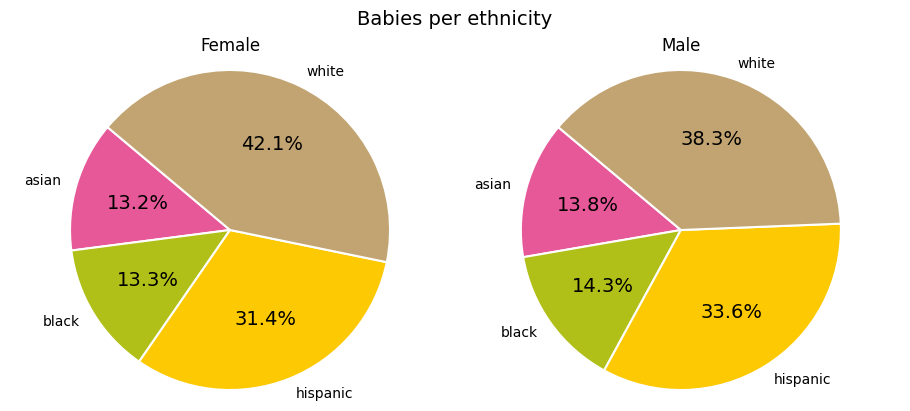

In [11]:
#define a function to create the pie charts for our plot
def plot_pie_charts(df_percent_pooled):
    
    #set style and palette
    sns.set_palette(palette_ethnicities)

    #create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(plot_size_fullwidth*0.75, plot_size_onerowheight),layout="constrained")

    #plot pie chart for female
    plot_pie_chart(axs[0], df_percent_pooled, 'female', 'Female')

    #plot pie chart for male
    plot_pie_chart(axs[1], df_percent_pooled, 'male', 'Male')

    fig.suptitle('Babies per ethnicity')
    
    plt.show()

def plot_pie_chart(ax, df, gender_value, gender_label):
    df_gender = df[df['gender'] == gender_value]
    ax.set_title(f'{gender_label}')
    ax.pie(df_gender['total_percentage'], labels=df_gender['ethnicity'], autopct='%1.1f%%', startangle=140,
           wedgeprops=dict(edgecolor='white', width=1, linewidth=1.5))
    ax.axis('equal')  #equal aspect ratio ensures that pie is drawn as a circle

#call function
plot_pie_charts(df_percent_pooled)

It looks like, for both genders, there's a big unbalance among ethnicities in NYC, with White and Hispanic babies making most of the population. The difference in size among ethnicity categories could skew some of our subsequent analyses. To avoid this, it would be appropriate to compute a percentage measure. This would inform us of which percentage babies with a certain name represent over the total newborns for that gender and ethnicity. Let's do it for both the pooled and the per-year data frames.


In [12]:
#obtaining percentage of each name within each gender and ethnicity (and year in the per year data frame)
df_babynames_pooled['percentage'] = df_babynames_pooled.groupby(['gender', 'ethnicity'])['count'].transform(lambda x: (x / x.sum())*100) #pooled data frame

df_babynames['percentage'] = df_babynames.groupby(['gender', 'ethnicity', 'year_born'])['count'].transform(lambda x: (x / x.sum())*100) #per-year data frame

#display pooled data frame as an example
display(df_babynames_pooled)

,gender,ethnicity,name,count,rank,percentage
0,female,asian,Aaliyah,21,241.0,0.059932
1,female,asian,Aarya,21,241.0,0.059932
2,female,asian,Aayat,10,287.0,0.028539
3,female,asian,Abby,148,81.0,0.422374
4,female,asian,Abigail,271,28.0,0.773402
...,...,...,...,...,...,...
3266,male,white,Zakaria,10,476.0,0.007691
3267,male,white,Zalmen,94,288.0,0.072298
3268,male,white,Zane,10,476.0,0.007691
3269,male,white,Zayn,62,320.0,0.047686


Very well, now we have a `percentage`column that could come in handy. We could, for instance, visualize the distribution of those percentages as a density plot. We'll first create the figure and then explain what we see.

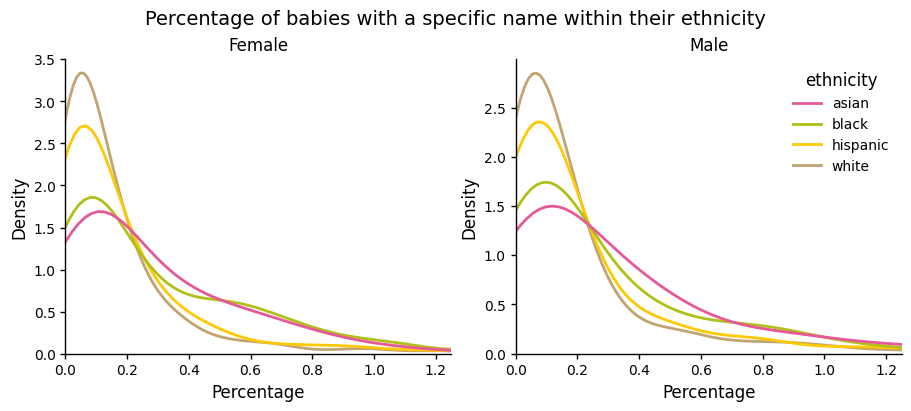

In [13]:
#get unique values from the specified column for subplots
categories = df_babynames_pooled['gender'].unique()

#create a common legend outside of the subplots
legend_labels = df_babynames_pooled['ethnicity'].unique()

#create figure and array of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(plot_size_fullwidth*0.75, plot_size_onerowheight),layout="constrained")

#flatten the array of subplots for easier indexing
axes = axes.flatten()

#loop
for i in range(len(categories)):
    
    #choose slice of data for that subplot
    ax = axes[i]
    category_value = categories[i]
    subset_df = df_babynames_pooled[df_babynames_pooled['gender'] == category_value]

    #make plot
    sns.kdeplot(
        ax=ax,
        data=subset_df,
        x='percentage',
        hue="ethnicity",
        common_norm=False,
        fill=False,
        alpha=1,
        linewidth=2,
        palette=palette_ethnicities,
        hue_order=legend_labels
    )
    
    #customize subplot
    ax.set_title(category_value.capitalize())
    ax.set(xlim=(0, 1.25), ylim=(0, None))
    apply_common_settings(ax)  #apply our predefined common settings
    ax.set_xlabel("Percentage")
    ax.set_ylabel("Density")

#keep only one legend, and remove box around it
axes[0].get_legend().remove()  #remove legend from this subplot
axes[1].get_legend().get_frame().set_linewidth(0)  #remove legend outline
axes[1].get_legend().get_frame().set_facecolor('none')  #set legend background color to none

#set general title
fig.suptitle('Percentage of babies with a specific name within their ethnicity')

#show the plot
plt.show()

So what do we see? The figure shows, for each gender and ethnicity, the density, that could be understood as some sort of probbability, that a given name is shared by a certain percentage of the babies. Densities have a peak, which for all densities seems to be around 0.1, meaning that 0.1 is the most likely percentage of the babies a particular name is shared among.

When comparing the densities between genders, it looks like there are not many differences. But when comparing among ethnicities, we can see that the peak for the _white_ and _hispanic_ densities is higher, while the distributions for _asian_ and _black_ have 'fatter' tails. This can be interpreted as the latter ethnicities having more names that are given to a big chunk of babies. That is, they have more superpopular names. To find support for this hypothesis, let's explore the data a bit more. A thing we could do is finding out what the top 5 names for each gender and ethnicity are, and seeing which percentage of the babies for that gender and ethnicity were named with a top 5 name.

In [14]:
#copy pooled DataFrame and assign new variable name to it
df_babynames_top5 = df_babynames_pooled.copy()

#order the data frame by gender, ethnicity, rank
df_babynames_top5 = df_babynames_top5.sort_values(by=['gender', 'ethnicity', 'rank'])

#filter the data to keep only the top-5 names
df_babynames_top5 = df_babynames_top5[df_babynames_top5['rank'] <= 5]

df_babynames_top5perc = df_babynames_top5.groupby(['gender', 'ethnicity'])['percentage'].sum().reset_index()

display(df_babynames_top5perc)

,gender,ethnicity,percentage
0,female,asian,13.607306
1,female,black,9.263798
2,female,hispanic,12.044647
3,female,white,8.390118
4,male,asian,14.270822
5,male,black,11.008628
6,male,hispanic,10.985459
7,male,white,8.829615


The `percentage` column tells us what we wanted to know: that is, which percentage of babies were given one of the top 5 names within their gender and ethnicity. For males, the data seems to be in line with our hypothesis, as this percentage is higher for Asian and Black babies. For females, Hispanic babies seem to be named more with these popular names than Black babies. In any case, within both genders Asian babies have the biggest percentage, and White babies the smallest.

The data tells us that the 5 more popular names for Asian and Black babies are given to more newborns within their communities, in relative terms, than the top 5 names for Hispanic and White babies are given within theirs. It would be easy to stretch that and claim that the Asian and Black communities have a more reduced name pool. But that's not necessarily true. If we calculated the number of unique names and saw that this is smaller for those ethnicities, it could just be a product of those communities being smaller (i.e. having less people). So why don't we calculate how many unique names per person each ethnicity has?

In [15]:
#group by gender and ethnicity and calculate the number of unique names
name_range_df = df_babynames_pooled.groupby(['gender', 'ethnicity'])['name'].nunique().reset_index()

#group by gender and ethnicity and calculate the total count
total_count_df = df_babynames_pooled.groupby(['gender', 'ethnicity'])['count'].sum().reset_index()

#merge the two dataframes on gender and ethnicity
result_df = pd.merge(name_range_df, total_count_df, on=['gender', 'ethnicity'], how='outer')

#rename columns
result_df = result_df.rename(columns={'name': 'unique_names', 'count': 'total_count'})

#calculate number of unique names per person
result_df['unique_names_per_person'] = result_df['unique_names'] / result_df['total_count']

#display the DataFrame
display(result_df)

,gender,ethnicity,unique_names,total_count,unique_names_per_person
0,female,asian,310,35040,0.008847
1,female,black,321,35493,0.009044
2,female,hispanic,513,83589,0.006137
3,female,white,599,112120,0.005342
4,male,asian,287,47005,0.006106
5,male,black,309,48680,0.006348
6,male,hispanic,424,114160,0.003714
7,male,white,508,130017,0.003907


Well, look at that. The data runs against the intuition. The Asian and Black communities have actually a relatively bigger name pool, once we factor their size in. This is such an interesting discovery, and it reveals a fairly complex naming pattern. Some ethnicities relying more on their popular names does not lead them to a narrower name pool.

## 5. Most common names
We've just been talking about the most popular names, but we did not get the chance to know what these names are. Our curiosity could be easily satisfied if we simply visualized our top 5 names DataFrame, shown below.

In [16]:
#display the DataFrame we created earlier
print(df_babynames_top5)

      gender ethnicity     name  count  rank  percentage
239   female     asian   Olivia   1185   1.0    3.381849
77    female     asian    Chloe   1095   2.0    3.125000
277   female     asian   Sophia    943   3.0    2.691210
107   female     asian     Emma    777   4.0    2.217466
106   female     asian    Emily    768   5.0    2.191781
...      ...       ...      ...    ...   ...         ...
2880    male     white    David   2485   1.0    1.911289
3011    male     white   Joseph   2464   2.0    1.895137
3085    male     white  Michael   2226   3.0    1.712084
3098    male     white    Moshe   2159   4.0    1.660552
2987    male     white    Jacob   2146   5.0    1.650553

[40 rows x 6 columns]


This DataFrame has five rows per gender and ethnicity, and these five rows contain their respective top 5 most popular names. For each name, we have the total count, rank and percentage per gender and ethnicity. Let's create a function to display, as a bar plot, the count for each name in our top 5 DataFrame.

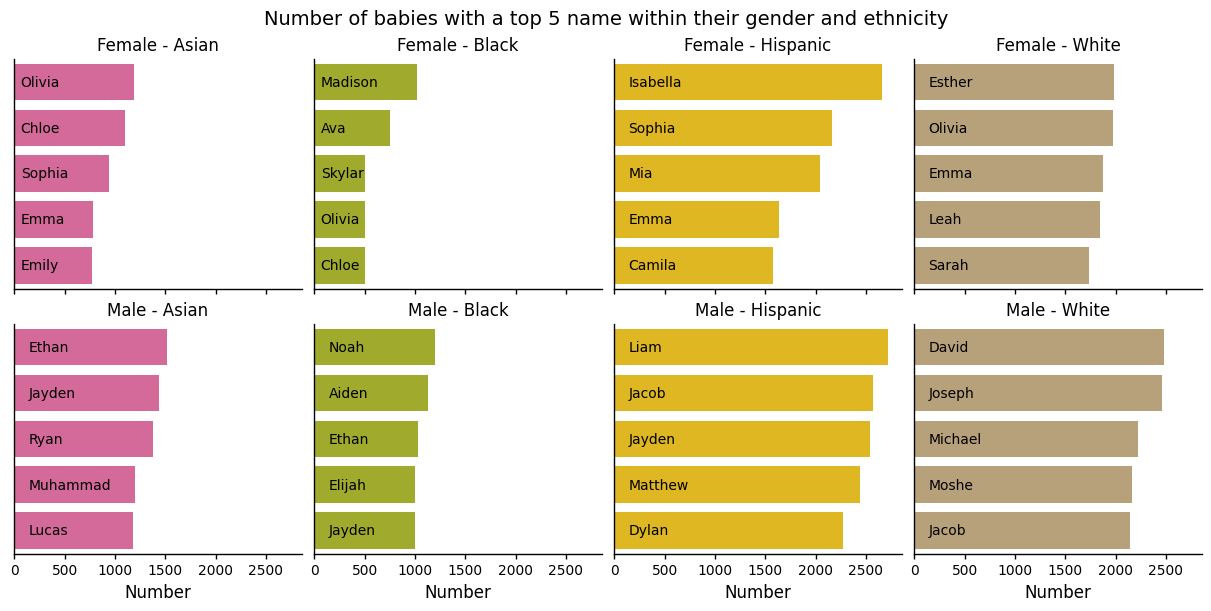

In [17]:
def plot_babynames(df):
    # set up the figure
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(plot_size_fullwidth, plot_size_onerowheight*1.5), sharex=True,layout="constrained")

    # flatten the 2D array of axes to make it easier to iterate
    axes = axes.flatten()

    # define the order of ethnicities for consistent plotting
    legend_labels = df['ethnicity'].unique()

    # loop through gender and ethnicity
    for j, gender in enumerate(['female', 'male']):
        for i, ethnicity in enumerate(legend_labels):
            # DataFrame subset of interest
            df_subset = df[(df['ethnicity'] == ethnicity) & (df['gender'] == gender)]

            # plot
            sns.barplot(x='count', y='rank', data=df_subset, ax=axes[j * 4 + i], hue='ethnicity', palette=[palette_ethnicities[i]], orient='h')

            # annotate bars with the 'name' values
            for index, row in df_subset.iterrows():
                # get x-axis limits and adjust x-position accordingly
                x_position = axes[j * 4 + i].get_xlim()[1] * 0.05
                axes[j * 4 + i].text(x_position, row['rank'] - 1, row['name'], ha='left', va='center', color='black', fontsize =font_size_regular-2)

            # set title and labels
            axes[j * 4 + i].set_title(f'{gender.capitalize()} - {ethnicity.capitalize()}')
            axes[j * 4 + i].set_xlabel('Number')

            # remove y-axis ticks, labels, and title
            axes[j * 4 + i].tick_params(left=False, labelleft=False)
            axes[j * 4 + i].set_ylabel('')
            axes[j * 4 + i].set_yticklabels([])

            # apply predefined settings to this subplot
            apply_common_settings(axes[j * 4 + i])

            # remove legend
            axes[j * 4 + i].get_legend().remove()  # remove legend from this subplot

    #set general title
    fig.suptitle('Number of babies with a top 5 name within their gender and ethnicity')

    # show the plot
    plt.show()

# call the function
plot_babynames(df_babynames_top5)

As intended, above we plotted the top 5 names per gender and ethnicity, with their respective counts represented by the length of the bars. The counts are much smaller for Black and Asian babies, mainly because the overall number of newboens is smaller than for the Hispanic and White population. But that we knew already. So what's interesting in this plot? Well, we can see that some popular names are so for more than one ethnicity. For females, Olivia and Emma appear in three out of the four top fives. Jayden seems to be the equivalent for male babies. When looking at each individual top 5, we can see that no name reigns supreme over the others, each being closely followed in count by the next in rank.

So far we've seen each ethnicity's top 5, but it could also be interesting to see the each gender's top 5 overall across ethnicities. Getting there should be easy.

In [18]:
#sum up the counts for each name across all ethnicities within each gender
df_df_top5_overall_sum = df_babynames_pooled.groupby(['gender', 'name'])['count'].sum().reset_index()
df_df_top5_overall_sum['rank'] = df_df_top5_overall_sum.groupby('gender')['count'].rank(ascending=False, method='max')
df_df_top5_overall_sum = df_df_top5_overall_sum.sort_values(by=['gender', 'rank'])

#find the 5 most common names within each gender
df_top5_overall = df_df_top5_overall_sum[(df_df_top5_overall_sum['rank'] <= 5)]

#display the DataFrame
display(df_top5_overall)

,gender,name,count,rank
966,female,Sophia,4814,1.0
462,female,Isabella,4584,2.0
807,female,Olivia,4492,3.0
339,female,Emma,4477,4.0
729,female,Mia,4197,5.0
1357,male,Ethan,5867,1.0
1455,male,Jacob,5649,2.0
1605,male,Liam,5453,3.0
1493,male,Jayden,5210,4.0
1731,male,Noah,5171,5.0


Easy indeed. Unsurprisingly, all of the names we see here we had already seen in the per-ethnicity top 5s. A final related question is which ethnicity drives the overall popularity of these names. An easy answer would be that it's the ethnicities with the most demographic weight: Whites and Hispanics. But let's see if we're in for another surprise. First we'll obtain one DataFrame per gender where we'll have the number of babies of each ethnicity named with one of the overall (ethnicity-independent) top 5 names. 

In [19]:
#create separate DataFrames for females and males
df_top5_overall_female = df_top5_overall[df_top5_overall['gender'] == 'female']
df_top5_overall_male = df_top5_overall[df_top5_overall['gender'] == 'male']

#create lists with the top 5 overall names for each gender
list_top5_overall_female = df_top5_overall_female['name'].tolist()
list_top5_overall_male = df_top5_overall_male['name'].tolist()

#take the original pooled DataFrame and filter it so it only includes those names from the lists above
df_top5_ethnicity_in_overall_female = df_babynames_pooled[(df_babynames_pooled['gender'] == 'female') & (df_babynames_pooled['name'].isin(list_top5_overall_female))]
df_top5_ethnicity_in_overall_male = df_babynames_pooled[(df_babynames_pooled['gender'] == 'male') & (df_babynames_pooled['name'].isin(list_top5_overall_male))]

#drop rank columns because we will get the overall ones below
df_top5_ethnicity_in_overall_female = df_top5_ethnicity_in_overall_female.drop('rank', axis=1)
df_top5_ethnicity_in_overall_male = df_top5_ethnicity_in_overall_male.drop('rank', axis=1)

#merge the new DataFrames with the ones with overall rank information
df_top5_ethnicity_in_overall_female = pd.merge(df_top5_ethnicity_in_overall_female, df_top5_overall_female[['name', 'rank']], on='name', how='left')
df_top5_ethnicity_in_overall_male = pd.merge(df_top5_ethnicity_in_overall_male, df_top5_overall_male[['name', 'rank']], on='name', how='left')

We'll skip displaying the DataFrames and interpret the data by means of a figure. A candidate type of visualization here could be a stacked bar plot. Each bar should be one of the top 5 overall names, composed of stacked bars that would be colored according to ethnicity, with the length of each part of the bar representing the amount of babies within that ethnicity that were given that name.

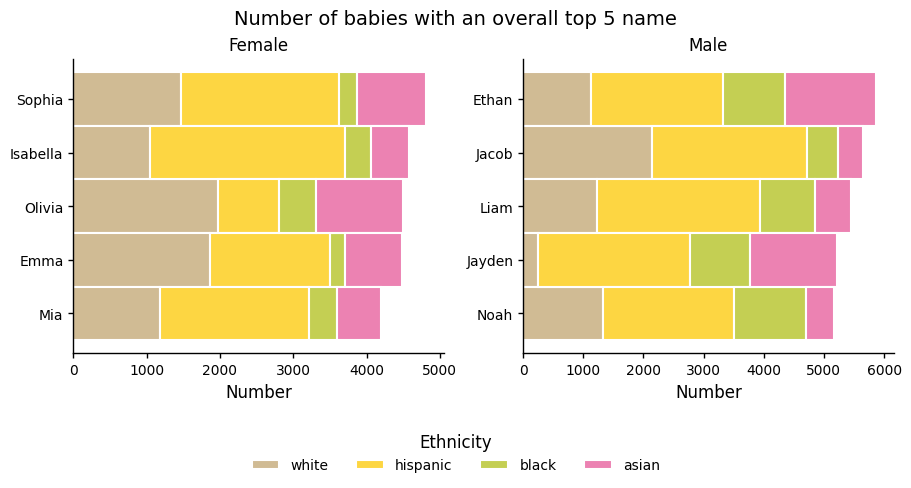

In [20]:
def plot_topnames_as_stacked_bars(ax, df, gender, palette):
    #get the order of 'name' based on 'rank'
    name_order = df.sort_values('rank')['name'].unique()

    #set the 'name' column as a categorical variable with the desired order
    df['name'] = pd.Categorical(df['name'], categories=name_order, ordered=True)

    #plot
    sns.histplot(
        data=df,
        weights='count',
        y='name',
        hue='ethnicity',
        multiple='stack',
        palette=palette,
        ax=ax
    )

    #customize bar outlines
    for patch in ax.patches:
        patch.set_edgecolor('white')
        patch.set_linewidth(1.5)

    apply_common_settings(ax) 

    #set plot title and labels
    ax.set_title(f'{gender.capitalize()}')
    ax.set_xlabel('Number')
    ax.set_ylabel('Name')

    return ax

#create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(plot_size_fullwidth*0.75, plot_size_onerowheight),layout="constrained")

#subplot for females
ax_female = plot_topnames_as_stacked_bars(axes[0], df_top5_ethnicity_in_overall_female, 'female', palette_ethnicities)

#subplot for males
ax_male = plot_topnames_as_stacked_bars(axes[1], df_top5_ethnicity_in_overall_male, 'male', palette_ethnicities)

#remove individual legends for subplots
ax_female.get_legend().remove() 
ax_male.get_legend().remove()

#remove y-axis title
ax_female.set_ylabel('')
ax_male.set_ylabel('')

#set a single legend
legend = fig.legend(
    title='Ethnicity',
    labels=['white','hispanic','black','asian'],
    loc='lower center', 
    bbox_to_anchor=(0.5, -0.2), 
    fancybox=False, 
    shadow=False, 
    ncol=4) 

#adjust legend width
legend.get_frame().set_linewidth(0) #remove legend outline
legend.get_frame().set_facecolor('none') #set legend background color to none

#set general title
fig.suptitle('Number of babies with an overall top 5 name')

#show the plot
plt.show()


The most interesting things we can appreciate in the figure above is that some ethnicities contribute to these overall top 5 names above their demographic weight, while some barely contribute to them. In a lot of cases for both genders, we see that Hispanic babies are the ones who bear these names the most often. On the other hand, Black babies are on the opposite end, particularly for female names. The Hispanic community seems to be at the center of trends, huh? We'll get back to it later in the next section.

Anecdotically, we see a curious outlier. Despite Jayden being one of the most popular names overall, White babies barely received that name. Actually, in our previous figure we could already see a hint of that, as the only male top 5 Jayden was absent of was that for the White ethnicity.

## 6. Measuring name overlap between pairs of ethnicities with cosine similarity
We've taken a look at demographics and at popular names. Let's focus on something even more ambitious: quantifying name overlap between pairs of ethnicities. There are probably different ways in which we could do so, but a simple path is using cosine similarity, which quantifies how similar two sets of data are. Specifically, cosine similarity is a mathematical measure that calculates the cosine of the angle between two vectors. In our case, the vectors represent the frequency of names within each ethnicity. The final statistic ranges from 0 to 1. The higher the cosine similarity between a pair of ethnicities, the more similar the naming patterns between them.

In order to make the most of out this overlap measure, we're gonna calculate it both for the pooled and the per-year data frames. To be more efficient, we'll code a function that will be flexible enough to take care of the calculation for both. Since we'll have plenty of cosine similarity matrix-like DataFrames, we'll store them in a dictionary.

In [21]:
def calculate_cosine_similarity(df, year_born):
    
    #create a function within the function that wrangles the input DataFrame and calculates the cosine similarity
    def calculate_similarity(filtered_df):
        #pivot the dataframe
        pivot_df = filtered_df.pivot_table(index='name', columns='ethnicity', values='percentage', fill_value=0)

        #calculate cosine similarity matrix
        cosine_similarity_matrix = cosine_similarity(pivot_df.T)

        #create a DataFrame from the similarity matrix
        cosine_similarity_df = pd.DataFrame(cosine_similarity_matrix, index=pivot_df.columns, columns=pivot_df.columns).reset_index()
        cosine_similarity_df.columns.name = None  #remove the name for the index column

        return cosine_similarity_df

    result_dict = {}

    #get unique genders
    genders = df['gender'].unique()

    #loop over genders and (if necessary) over years
    for current_gender in genders:
        
        filtered_df = df[df['gender'] == current_gender] #filter the dataframe based on current_gender

        if year_born == 'pooled':
            result_dict[current_gender] = calculate_similarity(filtered_df) #pass previous function

        elif year_born == 'split':
            
            years = filtered_df['year_born'].unique() #get unique years

            for current_year in years:
                
                current_year_df = filtered_df[filtered_df['year_born'] == current_year] #filter the dataframe for the current year

                result_dict[(current_year, current_gender)] = calculate_similarity(current_year_df) #pass previous function

    return result_dict

#pass the function and create two dictionaries storing the cosine similarity between pairs of ethnicities, always split per gender, but one pooling over years and one split per year
result_dict_allyears = calculate_cosine_similarity(df_babynames_pooled, year_born = 'pooled') #pooled across all years
result_dict_peryear = calculate_cosine_similarity(df_babynames, year_born = 'split') #split per year

We now have two dictionaries, one with the cosine similarity pseudomatrices (as they are actually DataFrames) for each gender of the pooled data frame, and one with the pseudomatrices for each gender and year. For instance, we can access the element for the female babies in the pooled dictionary like this.

In [22]:
#display element of the pooled cosine similarities dictionary corresponding to female babies
display(result_dict_allyears[('female')])

,ethnicity,asian,black,hispanic,white
0,asian,1.000000,0.476673,0.647551,0.646255
1,black,0.476673,1.000000,0.533382,0.410907
2,hispanic,0.647551,0.533382,1.000000,0.578942
3,white,0.646255,0.410907,0.578942,1.000000


As said, despite being a pandas DataFrame, this really looks like a matrix with a cosine similarity value for each pair of ethnicities. We can also retrieve an element of the per-year dictionary, for instance that for female babies born in 2011.

In [23]:
#display element of the per-year cosine similarities dictionary corresponding to female babies born in 2011
display(result_dict_peryear[(2011,'female')])

,ethnicity,asian,black,hispanic,white
0,asian,1.000000,0.343354,0.592970,0.574569
1,black,0.343354,1.000000,0.473151,0.347840
2,hispanic,0.592970,0.473151,1.000000,0.555662
3,white,0.574569,0.347840,0.555662,1.000000


How to visualize these? Since each element resembles a lot a correlation matrix, we could simply stick to the common practice and create a bunch of heatmaps. As we have all the elements stored, we could plot them if we want to. But that would be overwhelming. Instead of that, we'll just process the data and store it in another pair of dictionaries, ready to be plotted. And why should the data be processed further? Well, because I like my heatmaps to avoid any redundance: why showing the cosine similarity information for the row-column pair of hispanic-black if we already saw the exact same value for black-hispanic? Also,I don't find it interesting to see cells with 1s when comparing the same ethnicity. Convinced? Let's clean up a bit before plotting then!

In [24]:
#define function to create heatmap data that we can then plot
def create_cosine_similarity_heatmaps(result_dict, year_born):
    heatmap_data = {}

    for key, cosine_similarity_df in result_dict.items():
        if year_born == 'pooled':
            current_gender = key
            current_year = 'allyears'
        else:
            current_year, current_gender = key

        #adjust the name for the plot based on the input parameters
        plot_name = f"fig_heat_{current_gender}_{current_year}"

        #aet 'ethnicity' as the index
        cosine_similarity_df = cosine_similarity_df.set_index('ethnicity')

        #create a mask to hide the upper triangle and the diagonal
        mask = np.triu(np.ones_like(cosine_similarity_df, dtype=bool))

        #exclude the bottom row and rightmost column from display
        heatmap_data[plot_name] = cosine_similarity_df.iloc[1:, :-1].mask(mask[1:, :-1])

    return heatmap_data

#pass the function and create two dictionaries storing data for heatmaps based on previous cosine similarity matrices
heatmap_figures_allyears = create_cosine_similarity_heatmaps(result_dict_allyears, year_born = 'pooled') #pooled over years
heatmap_figures_peryear = create_cosine_similarity_heatmaps(result_dict_peryear, year_born = 'split') #split per year

#display the pooled dictionary as an example
display(heatmap_figures_allyears)

{'fig_heat_female_allyears':               asian     black  hispanic
 ethnicity                              
 black      0.476673       NaN       NaN
 hispanic   0.647551  0.533382       NaN
 white      0.646255  0.410907  0.578942,
 'fig_heat_male_allyears':               asian     black  hispanic
 ethnicity                              
 black      0.590672       NaN       NaN
 hispanic   0.685889  0.726183       NaN
 white      0.557021  0.489315  0.624546}

Okay, we're done. For illustrative purposes, we plotted the pooled dictionary above. Each of the two elements of this dictionary now takes the form of the lower diagonal of a correlation matrix, with no identity cells. In other words, we keep only the non-redundant information.

We probably don't want to see the plots for all matrices. So let's just focus on the cosine similarities made from the pooled data frames. 

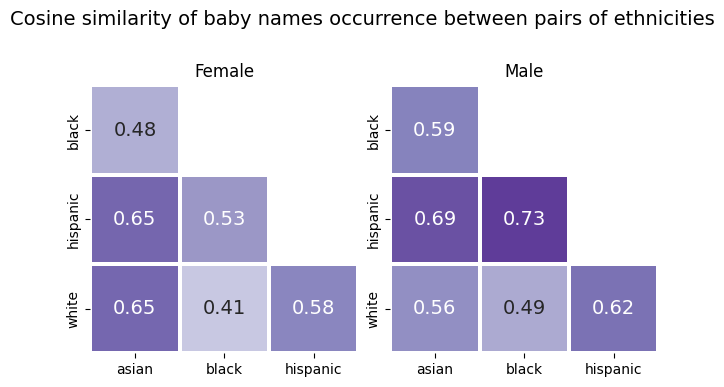

In [25]:
#define figure layout
fig, axes = plt.subplots(1, 2, figsize=(plot_size_fullwidth*0.5, plot_size_onerowheight),layout="constrained")

#display the female heatmap on the first subplot
sns.heatmap(heatmap_figures_allyears["fig_heat_female_allyears"], ax=axes[0], cmap="Purples", vmin=0.2, vmax=0.85, annot=True, linewidth=1.5, fmt=".2f", cbar=False, square=True)
axes[0].set_title('Female')

#display the male heatmap on the second subplot
sns.heatmap(heatmap_figures_allyears["fig_heat_male_allyears"], ax=axes[1], cmap="Purples", vmin=0.2, vmax=0.85, annot=True, linewidth=1.5, fmt=".2f", cbar=False, square=True)
axes[1].set_title('Male')

#set y-axis label to an empty string for both subplots
[ax.set_ylabel("") for ax in axes]

#set general title
plt.suptitle('Cosine similarity of baby names occurrence between pairs of ethnicities')

#show the plot
plt.show()

Nice and clean! Each cell contains the value of the cosine similarity between the pair of ethnicities of the respective row and column. Moreover, we added a gradient color coding that intuitively displays the pairs of ethnicities with the highest and lowest name overlap. At a first glance, it looks like similarity for baby girls is lower than for baby boys. Within each heatmap, some ethnicities seem to consistently have lower cosine similarity than others. For instance, the Black ethnicity seems to have lower overall overlap. The opposite appears to be the case for the Hispanic community, particularly for males.

It may be worth pursuing the two hunches we just verbalized. But as a small detour, let's just show how we can also plot some of the elements for the per-year dictionary. Following the element we chose as an example earlier, let's create a heatmap for the females born in 2011.

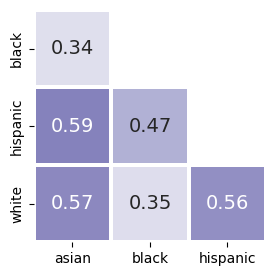

In [26]:
#plot the cosine similarity heatmap for the females born in 2011
plt.figure(figsize=(plot_size_fullwidth*0.25, plot_size_onerowheight))
sns.heatmap(heatmap_figures_peryear["fig_heat_female_2011"], cmap="Purples", vmin=0.2, vmax=0.85, annot=True, linewidth=1.5,
            fmt=".2f", cbar=False, square=True)
plt.ylabel("")
plt.show()

Done. So, where were we? Oh yeah, we wanted to pull the thread a bit more in order to confirm or disconfirm two hastily-made hypotheses:
1. Across genders, cosine similarity is generally lower for females than for males.
2. For both genders, cosine similarity is generally lower for some ethnicities than for others.

Let's tackle hypothesis 1. Since we're comparing only two groups, and these have all values belonging to the same 'conditions' (years, pairs of ethnicities), an easy way to go would be to run a paired samples t-test. And even if we could do it with the cosine similarities from our pooled data, we'll throw power into the analysis by using the nine times as many data points contained in the per-year data. So let's create a function that wrangles the cosine similarity data from out dictionary and transforms it into the long DataFrames we need.

In [27]:
#define function accesing dictionary cosine similarity data and turning it to long format
def dfcosim_to_long(df,gender):

    final_df = pd.DataFrame()

    #loop over years
    for current_year in range(2011, 2020):
        
        filtered_df = df[(current_year,gender)] #subset of data for current year

        #turn df to long format
        filtered_df = filtered_df.melt(id_vars=['ethnicity'], value_vars=['asian', 'black', 'hispanic', 'white'], var_name='ethnicity2', value_name='cosine_similarity')

        #use frozenset to remove duplicate pairs of ethnicities (regardles of the order)
        filtered_df['frozenset'] = filtered_df.apply(lambda row: frozenset([row['ethnicity'], row['ethnicity2']]), axis=1)
        filtered_df = filtered_df[~filtered_df.duplicated(subset='frozenset', keep='first')]

        #eliminate rows for which cosine similarity was calculated for pairs of the same ethnicities (and thus equals 1), as we do not want them for our analysis
        filtered_df = filtered_df[filtered_df['cosine_similarity']  < 0.9999] # doing the < 0.9999 trick because numeric value of 1 followed by several 0s gives some problems

        #create new variable identifying each pair of ethnicities
        filtered_df['ethnicity_pair'] = filtered_df['ethnicity'] +"_"+ filtered_df['ethnicity2']

        #keep only the columns we want
        filtered_df = filtered_df.filter(items=['ethnicity_pair','cosine_similarity'])

        #reset the row indices
        filtered_df = filtered_df.reset_index(drop=True)

        #add gender and year column
        filtered_df['gender'] = gender
        filtered_df['year_born'] = current_year

        #append current year's data to previous data
        final_df = pd.concat([final_df, filtered_df], ignore_index=True)

    return final_df

df_cosim_female_peryear_long = dfcosim_to_long(result_dict_peryear,'female')
df_cosim_male_peryear_long = dfcosim_to_long(result_dict_peryear,'male')

#display DataFrame for females as an example
display(df_cosim_female_peryear_long)

,ethnicity_pair,cosine_similarity,gender,year_born
0,black_asian,0.343354,female,2011
1,hispanic_asian,0.592970,female,2011
2,white_asian,0.574569,female,2011
3,hispanic_black,0.473151,female,2011
4,white_black,0.347840,female,2011
...,...,...,...,...
49,hispanic_asian,0.627307,female,2019
50,white_asian,0.599002,female,2019
51,hispanic_black,0.491896,female,2019
52,white_black,0.354872,female,2019


Instead of looping over both genders, we created a shorter function and called it twice with different arguments. Above we can see the format of the long DataFrame for females, but we also have a different one for males. Although we could join both, the paired samples t-test function does not require it, as long as both columns to compare are ordered the same way. Shall we run that t-test then? We'll supplement it with the difference in means between the cosine similarity data points for females and males.

In [28]:
#run the paired samples t-test
display(ttest_rel(df_cosim_female_peryear_long['cosine_similarity'], df_cosim_male_peryear_long['cosine_similarity']))

#calculate the difference in means
display(df_cosim_female_peryear_long['cosine_similarity'].mean() - df_cosim_male_peryear_long['cosine_similarity'].mean())

TtestResult(statistic=-5.434971310436123, pvalue=1.4110464365289522e-06, df=53)

-0.06872693826367449

A negative _t_ statistic and a negative difference of means suggests that cosine similarity for females is generally lower. And although the 0.07 points on average may seem small, the effect is very significant, as indicated by the p-value. So our first hypothesis is confirmed: boys have more similar names across ethnicities than girls.

On to the second hypothesis. How can we find out if some ethnicities have generally lower cosine similarity than others? We could do so by building a series of paired t-tests. Alternatively, we could build some linear models where we assess the effect of the presence of an ethnicity on cosine similarity values. But since this is just meant to be an exercise in exploration, we'll take the fast route and follow a descriptive approach. For each gender and ethnicity, we'll calculate the mean of unique cosine similarities each ethnicity is involved in. This will give us a value for each ethnicity that will represent its overall cosine similarity. Then we'll be able to see if both genders have the same patterns in terms of which ethnicities score higher and which score lower.

In [29]:
#create individual DataFrames for female and male
cossimmat_pooled_female = result_dict_allyears[('female')]
cossimmat_pooled_male = result_dict_allyears[('male')]

#define a function to calculate mean excluding the current ethnicity
def mean_excluding_current(row, df):
    current_ethnicity = row['ethnicity']
    columns_to_include = [col for col in df.columns if col != current_ethnicity and col != 'ethnicity']
    return row[columns_to_include].mean()

#pass the function to each row and create a new column 'mean_similarity'
cossimmat_pooled_female['mean_similarity'] = cossimmat_pooled_female.apply(mean_excluding_current, axis=1, df=cossimmat_pooled_female)
cossimmat_pooled_male['mean_similarity'] = cossimmat_pooled_male.apply(mean_excluding_current, axis=1, df=cossimmat_pooled_male)

#display the ethnicity label column and the newly created column
display(cossimmat_pooled_female[['ethnicity', 'mean_similarity']])
display(cossimmat_pooled_male[['ethnicity', 'mean_similarity']])

,ethnicity,mean_similarity
0,asian,0.590160
1,black,0.473654
2,hispanic,0.586625
3,white,0.545368


,ethnicity,mean_similarity
0,asian,0.611194
1,black,0.602057
2,hispanic,0.678873
3,white,0.556961


The top and bottom DataFrame slices we see above correspond to females and males, respectively. Each value gives us a measure of the general baby naming overlap each ethnicity shares with the others. The pattern seems to be different for each gender. On the higher end of cosine similarity, Hispanics easily seize the top spot for males, followed at a distance with Asians, while for females the distance is shorter but the rank is reversed, with Asians first and Hispanics a close second. When taking a look at the most dissimilar ethnicity, gender differences are more pronounced. For females, Black babies have by far the names with the least overlap with other ethnicities, whereas for males it is White babies. 

While we saw differences between genders, we can nevertheless extract a rough general trend: that the Hispanic and Asian ethnicities seem to have higher cosine similarity, and thus have names more common in other ethnicities, while the Black and White ethnicities seem to have lower cosine similarity, and thus have more unique names.

## 7. Overlap evolution across years
So far we've only used our per-year data to give more power to our analyses, but we haven't investigated whether any of the previous trends changed over years. This final hands-on section deals with such yearly approach. And since our cosine similarity measure has proved most meaningful, let's stick to it. We'll proceed like I like to: first we'll visualize and then we'll run some stats on any promising trend.

When conducting our t-test we already wrangled the data to obtain a long DataFrame containing the cosine similarity value for each year and ethnicity pair. The only problem is that we had two data frames of those, one for each gender, and now we'd like just one. Nothing easier than concatenating them though.

In [30]:
#concatenate the long data frames for the different genders
df_cosim_peryear_long = pd.concat([df_cosim_female_peryear_long,df_cosim_male_peryear_long], axis=0)

#display the DataFrame
display(df_cosim_peryear_long)

,ethnicity_pair,cosine_similarity,gender,year_born
0,black_asian,0.343354,female,2011
1,hispanic_asian,0.592970,female,2011
2,white_asian,0.574569,female,2011
3,hispanic_black,0.473151,female,2011
4,white_black,0.347840,female,2011
...,...,...,...,...
49,hispanic_asian,0.611328,male,2019
50,white_asian,0.515859,male,2019
51,hispanic_black,0.651836,male,2019
52,white_black,0.416035,male,2019


Ok, now we can plot, separately for each gender, how cosine similarity for each pair of ethnicities evolved from 2011 until 2019. We'll do it as a line plot with as many lines as ethnicity pairs, where the x-axis will be the year of birth of the babies, and the y-axis will be the cosine similarity value. As we've done before, we'll define a function, pass it to the data for each gender, and then create a figure with two subplots.

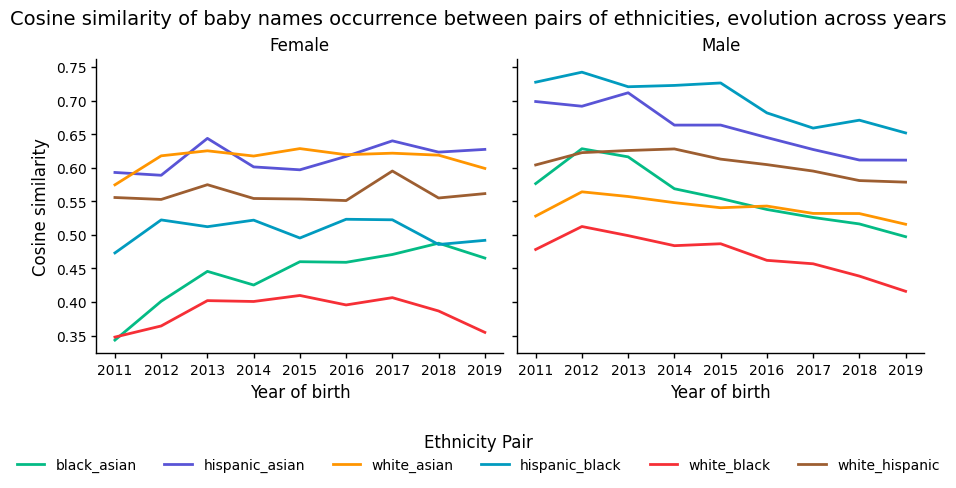

In [31]:
#define color palette for ethnicity pairs
palette_ethpairs = ['#04BB85', '#5954d6', '#FF9500', '#019BBF', '#F62F36', '#9D5E31']

#define the function to create the line plot
def plot_lines_yearly_cosine_similarity(df, gender, palette_ethpairs, ax):
    
    #filter data for the specified gender
    df_gender = df[df['gender'] == gender]

    #create lineplot
    sns.lineplot(
        data=df_gender,
        x='year_born',
        y='cosine_similarity',
        hue='ethnicity_pair',
        style='ethnicity_pair',
        markers=False,
        dashes=False,
        ax=ax,
        palette=palette_ethpairs,
        linewidth=2
    )
    
    #set title and axes
    ax.set_title(gender.capitalize())
    ax.set_xlabel('Year of birth')
    ax.set_ylabel('Cosine similarity')

    #remove legend from this subplot and apply custom graphical settings
    ax.get_legend().remove()  
    apply_common_settings(ax)

#create figure and define layout with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(plot_size_fullwidth*0.75, plot_size_onerowheight), sharey=True,layout="constrained")

#pass the function to each gender to create a plot and assign each to a different ax
plot_lines_yearly_cosine_similarity(df_cosim_peryear_long, 'female', palette_ethpairs, ax1)
plot_lines_yearly_cosine_similarity(df_cosim_peryear_long, 'male', palette_ethpairs, ax2)

#set a single legend for the plot
handles, labels = ax1.get_legend_handles_labels()
legend = fig.legend(handles, labels, title='Ethnicity Pair', loc='lower center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=len(labels))

#adjust legend settings
legend.get_frame().set_linewidth(0) #remove legend outline
legend.get_frame().set_facecolor('none') #set legend background color to none

#set general title
fig.suptitle('Cosine similarity of baby names occurrence between pairs of ethnicities, evolution across years')

#show the plot
plt.show()

I don't know if it's just me, but the trends here are quite clear. First, when comparing the y-axis between panels we can again corroborate that cosine similarity for males seems to be higher than for females. Then we could also try to begin discussing which line is above which within and across panels, but I'm not sure we want to take the time to do it. The really novel and interesting thing here is the changes along the x-axis. While for females there is no apparent change across years in cosine similarity, for males all lines go clearly down, meaning that cosine similarity shrank over the decade. If that was so, this means that, as years went by, names became more exclusive to each ethnicity. This is very exciting, and I think worthy of some statistical analysis.

Since we want to check for what seems to be a monotonic, linear trend, why not building a linear model? We can do it separately for each gender. In each model, cosine similarity will be predicted by the year babies were born in. 

In [32]:
#copy df and assign to new name
df_cosim_peryear_long_forlm = df_cosim_peryear_long.copy()

#convert variables to float64 (required for statsmodels)
df_cosim_peryear_long_forlm['cosine_similarity'] = df_cosim_peryear_long_forlm['cosine_similarity'].astype('float64')
df_cosim_peryear_long_forlm['year_born'] = df_cosim_peryear_long_forlm['year_born'].astype('float64')

#add a constant to the predictors (required for statsmodels)
df_cosim_peryear_long_forlm = sm.add_constant(df_cosim_peryear_long_forlm)

#create individual dfs for females and males
df_cosim_peryear_long_forlm_female = df_cosim_peryear_long_forlm[df_cosim_peryear_long_forlm['gender'] == 'female']
df_cosim_peryear_long_forlm_male = df_cosim_peryear_long_forlm[df_cosim_peryear_long_forlm['gender'] == 'male']

#fit the linear models for each gender
cosim_lm_female = sm.OLS(
    df_cosim_peryear_long_forlm_female['cosine_similarity'],
    df_cosim_peryear_long_forlm_female[['const','year_born']]).fit()

cosim_lm_male = sm.OLS(
    df_cosim_peryear_long_forlm_male['cosine_similarity'],
    df_cosim_peryear_long_forlm_male[['const','year_born']]).fit()

#display the summary of the lm for females as an example
display(cosim_lm_female.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      cosine_similarity   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.6040
Date:                Wed, 28 Feb 2024   Prob (F-statistic):              0.441
Time:                        18:19:01   Log-Likelihood:                 54.312
No. Observations:                  54   AIC:                            -104.6
Df Residuals:                      52   BIC:                            -100.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.9236      9.578     -0.723      0.473     -26.143      12.296
year_born      0.0037      0.005      0.777      0.441      -0.006       0.013
==============================================================================
Omnibus:                       11.565   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                4.221
Skew:                          -0.387   Prob(JB):                        0.121
Kurtosis:                       1.871   Cond. No.                     1.57e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It worked, and above we can see the summary of the model for females. But that's a lot of information. So we'll select only part of that information: the coefficients table.

In [33]:
#display the coefficients table of the model for females
display(cosim_lm_female.summary().tables[1])

,coef,std err,t,P>|t|,[0.025,0.975]
const,-6.9236,9.578,-0.723,0.473,-26.143,12.296
year_born,0.0037,0.005,0.777,0.441,-0.006,0.013


Much better. The coefficient associated to `year_born` is 0.0037, that value being the yearly increase in cosine similarity we would expect. However, the p-value accompanying the coefficient is only of 0.44, meaning that this effect is not significant.

Now we'll do the same for the linear model we ran for the male data.

In [34]:
#display the coefficients table of the model for males
display(cosim_lm_male.summary().tables[1])

,coef,std err,t,P>|t|,[0.025,0.975]
const,19.6748,8.453,2.328,0.024,2.713,36.637
year_born,-0.0095,0.004,-2.258,0.028,-0.018,-0.001


A significantly negative coefficient for `year_born`! In particular, we see that as each year goes by, in overall terms cosine similarity decreases by almost 0.01 points. The results for both models confirm our previous visual inspection: while names for female babies are not experiencing any change in overlap across ethnicities, for males they are increasingly becoming more dissimilar.

Can I bother you with one more thing? Let's build a more general model, with gender and year of birth as predictors. This will serve two purposes. First, if the gender coefficient is significant, we will strengthen our evidence for year-independent cosine similarity differences between genders. Second, if we test for the interaction between gender and year of birth, and this comes up significant, we will have more proof of differences between genders in the way cosine similarity evolves across years.

To run the 'complete' model, we have to turn `gender` into a float dummy variable, where, for instance, the value is 0 if the row concerns females, and 1 if it concerns males. We'll call it `gender_male`. Then we'll have to create an interaction term. Once we've done all that, we'll be able to fit the model.

In [35]:
#convert gender to float dummy variable
df_cosim_peryear_long_forlm = pd.get_dummies(df_cosim_peryear_long_forlm, columns=['gender'], drop_first=True) #create dummy variable
df_cosim_peryear_long_forlm['gender_male'] = df_cosim_peryear_long_forlm['gender_male'].astype(float) #convert newly creater gender_male to float

# Create interaction term between gender_male and year_born
df_cosim_peryear_long_forlm['interaction_gender_year'] = df_cosim_peryear_long_forlm['gender_male'] * df_cosim_peryear_long_forlm['year_born']

#fit the model
cosim_lm_both = sm.OLS(
    df_cosim_peryear_long_forlm['cosine_similarity'],
    df_cosim_peryear_long_forlm[['const', 'gender_male', 'year_born', 'interaction_gender_year']]).fit()

#display the coefficients table for the lm
display(cosim_lm_both.summary().tables[1])

,coef,std err,t,P>|t|,[0.025,0.975]
const,-6.9236,9.033,-0.766,0.445,-24.836,10.989
gender_male,26.5984,12.775,2.082,0.040,1.266,51.931
year_born,0.0037,0.004,0.824,0.412,-0.005,0.013
interaction_gender_year,-0.0132,0.006,-2.077,0.040,-0.026,-0.001


A lot to unpack here. First of all, although we should disregard the units of the coefficient, the effect of `gender_male`is significantly positive, meaning that cosine similarity is indeed higher for males. We can also see that `year_born` has no overall significant effect, but that's just probably the data for females hiding any effect present only for males. It's better to look at the interaction between gender and year of birth, which is significant, revealing a different relationship between year of birth and cosine similarity for each gender. And because we previously ran separate models for each gender, we already know the direction of each of these two different relationships.

No more modeling. I think it's time to wrap up.

## 8. Conclusion
On this project we aimed at characterizing the similarities and differences among ethnicities in the way babies are named. What follows is a summary of our main findings.

- Compared to the White and Hispanic communities, the Asian and Black population is characterized by a few very popular names that are used a lot, but also by a relatively bigger name pool.
- The Hispanic and Asian communities seem to share each more naming overlap with the rest of ethnicities, while the Black and White communities are those who have more names exclusive to their ethnicities.
- Name overlap seems to be different between genders, with male babies being named more similarly among ethnicities than female babies. Thus, girls have more ethnically-unique names.
- We can also observe different naming trends between genders across years. From 2011 to 2019, naming overlap among ethnicities remained similar for females, whereas for males it went down, meaning that each ethnicity gives their baby boys increasingly unique names.

And that's it! We extracted quite a few non-trivial insights from our dataset. Of course their meaningfulness depends on a few limitations. One is the surely non-monolithic ethnicity categories we used. Indeed, our white category includes babies of Anglo-Saxon extraction with common English names that other ethnicities could be more likely to adopt, but also a lot of Biblically-named Jewish babies. Since the Jewish community is particularly populous in New York City, our results may not extrapolate to other US cities or regions. Similarly, the 'Asian' label was applied to both people of East Asian (Chinese, Korean, Japanese) and South Asian (Bangladeshi, Indian, Pakistani) ancestry. Despite these limitations, I hope you've found this project interesting.
